# Exective summary of Work Package 3

## Objectives

In this WP, you will work on a given training dataset. Your goal is to develop a fault detection model using the regression algorithms learnt in the class, in order to achieve best F1 score。

## Tasks

- Task 1: Develop a regression model to predict the reference value for motor temperature.
- Task 2: Develop a fault detection model using the regression model you developed in Task 1.

## Delierables

- A Jupyter notebook reporting the process and results of the above tasks


# Before starting, please:
- Fetch the most up-to-date version of the github repository.
- Create a new branch with your name, based on the "main" branch and switch to your own branch.
- Copy this notebook to the work space of your group, and rename it to TD_WP_3_Your name.ipynb
- After finishing this task, push your changes to the github repository of your group.

# Task 1: Predict normal behaviors through regression models

In this task, let us try to develop a best regression model to predict the normal behaviors of a given motor. In this exercise, we can use motor 6 as an example. You can easilily generate the approach to other models for the data challenge.

We can use all the dataset where motor 6 works normally as our dataset. Then, we can run a cross validation (based on sequence, not points) to test the performances of the developed model.

In this example, we mainly use the following performance metrics:
- max error: The max error between the predicted and the true values.
- Mean root squared error: The mean root squared error between the predicted and the true values.
- Out-of-boundary rate: The percentage that the residual error between the predicted and the true values is larger than a given threshold. Here, we set the thresold to be $3$ degree.

## Sub-task 1: Only use the features at the current moment.

[This notebook](demo_regression_mdl.ipynb) provides a basic demonstration of how to set up the experiment. Let us start by considering only using the features from the current moment. In the notebook, we show a baseline using a simple linear regression with all the features. Could you please try to improve the performance of the model?

A few possible directions:
- Feature selection?
- Smoothing?
- Removing sequence-to-sequence variablity? Adding features regarding time dynamics (see the TD for last lecture).
- Changing to other regression models? For this, you can try different regression models from [here](https://scikit-learn.org/stable/supervised_learning.html)

Put your code below.

In [32]:
# Import the libraries

import sys
sys.path.insert(0, 'C:/Users/gioca/GitHub/projects/maintenance_industry_4_2024/supporting_scripts/WP_2_20240516/')
from utility import read_all_test_data_from_path, extract_selected_feature, prepare_sliding_window, FaultDetectReg, read_all_csvs_one_test, run_cv_one_motor
import numpy as np
from numpy import where
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import LocalOutlierFactor


In [33]:
# Data Reading and Outlier Removal
base_dictionary = 'C:/Users/gioca/GitHub/projects/maintenance_industry_4_2024/dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, is_plot=False)

normal_test_id = ['20240105_164214', '20240105_165300', '20240105_165972', '20240320_152031', '20240320_153841',
                  '20240320_155664', '20240321_122650', '20240325_135213', '20240426_141190', '20240426_141532',
                  '20240426_141602', '20240426_141726', '20240426_141938', '20240426_141980', '20240503_164435']

df_data = df_data[df_data['test_condition'].isin(normal_test_id)]

def removeoutliers (df, experiment, feature):

    model = LocalOutlierFactor(n_neighbors=20)
    df['indice'] = df.reset_index().index
    ds = df.loc[df['test_condition'] == experiment]
    x = pd.DataFrame(ds, columns=['indice',feature])
    model.fit_predict(x)
    lof = model.negative_outlier_factor_ 
    df_out = pd.DataFrame({'indice': x['indice'], 'lof': lof })

    return df_out

features = ['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage', 
            'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
            'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
            'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
            'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
            'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

for i in range(len(normal_test_id)):
    for j in range(len(features)):
        outliers = removeoutliers(df_data, normal_test_id[i], features[j])
        thresh1 = np.quantile(outliers.lof, 1/3000)
        index = where(outliers.lof<=thresh1)
        final_index = np.ravel(outliers['indice'].iloc[0] + index)
        df_data = df_data[~df_data['indice'].isin(final_index)]

In [3]:
# Definition of the Pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('regressor', LinearRegression())    # Step 2: Linear Regression
]

# Create the pipeline
mdl_linear_regreession = Pipeline(steps)

Model for motor 6:


c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

training performance, max error is: 19.566257407087605
training performance, mean root square error is: 2.6601695633324245
training performance, residual error > 1: 79.63588433973145%

 New run:

testing performance, max error is: 13.123969356904766
testing performance, mean root square error is: 4.521850840150715
testing performance, residual error > 1: 97.13756177924218%


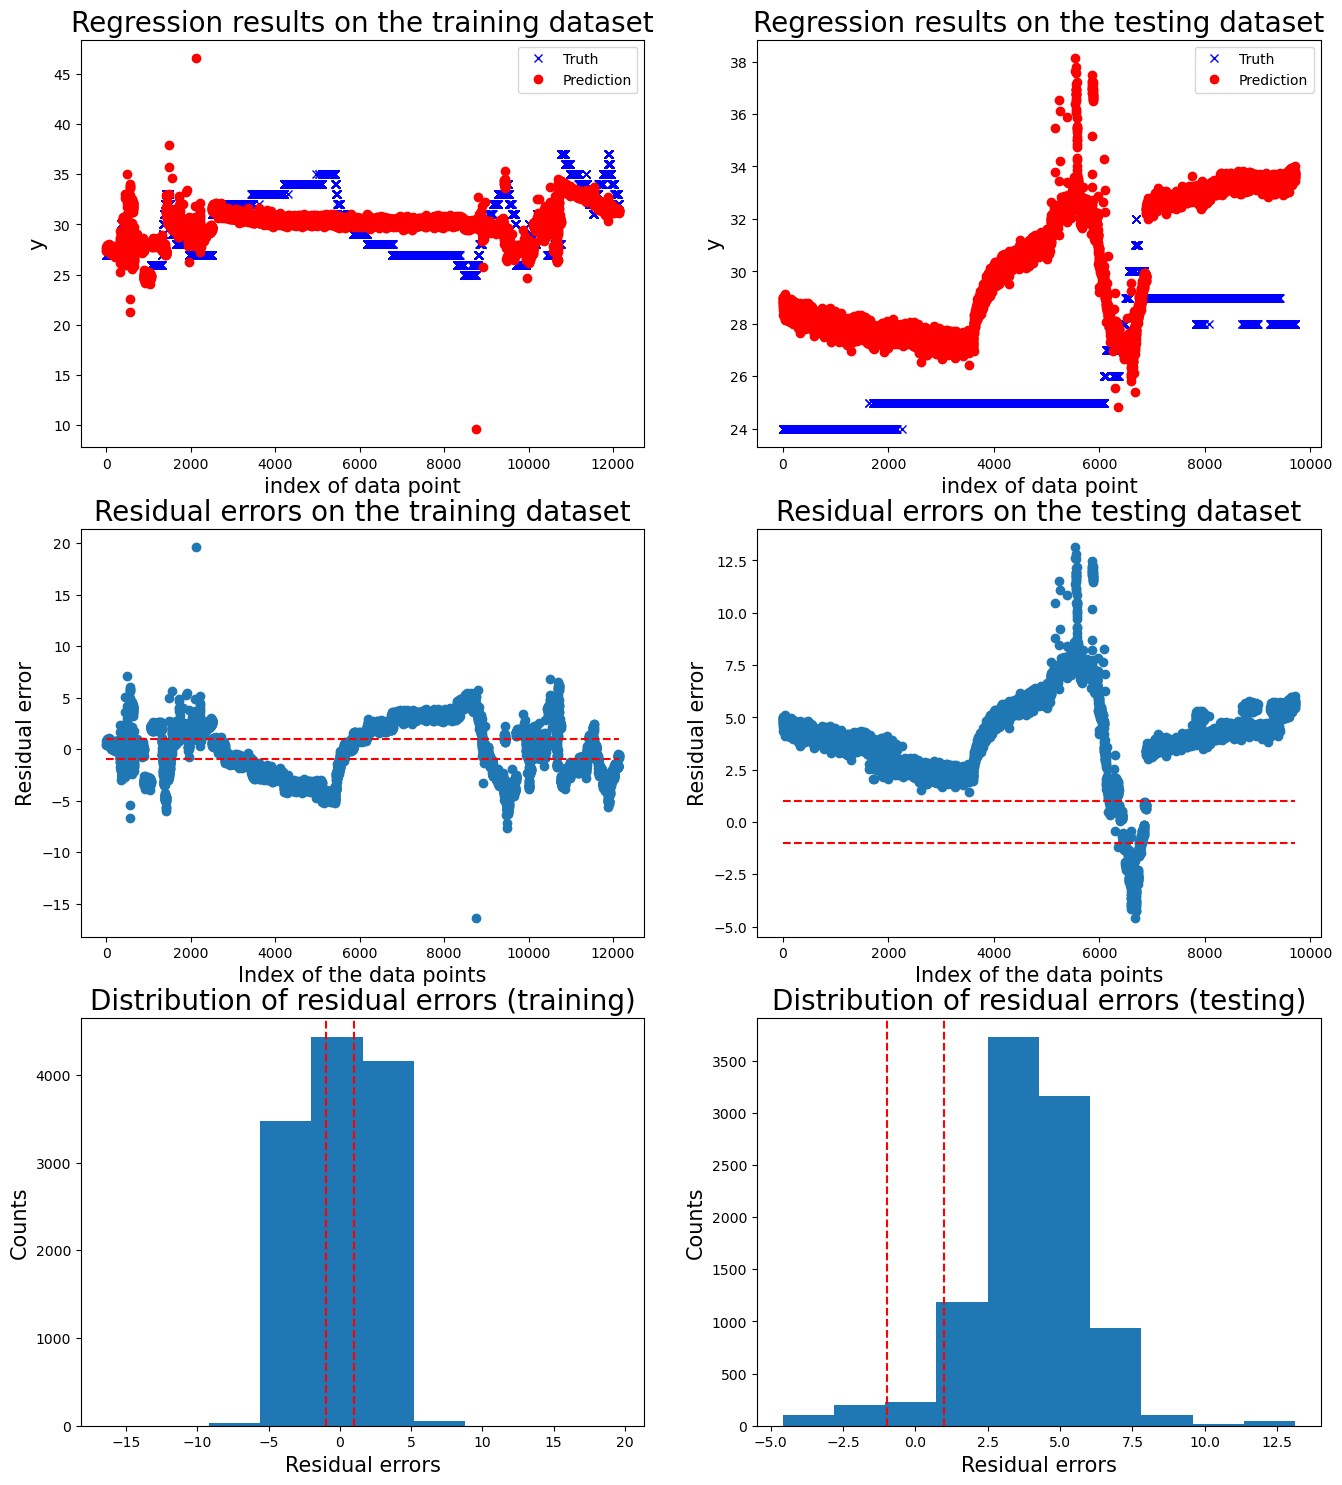

c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

training performance, max error is: 62.58380769317111
training performance, mean root square error is: 2.2180247578114654
training performance, residual error > 1: 60.60285563194078%

 New run:

testing performance, max error is: 12.759904979697515
testing performance, mean root square error is: 4.0334914078132345
testing performance, residual error > 1: 99.04761904761905%


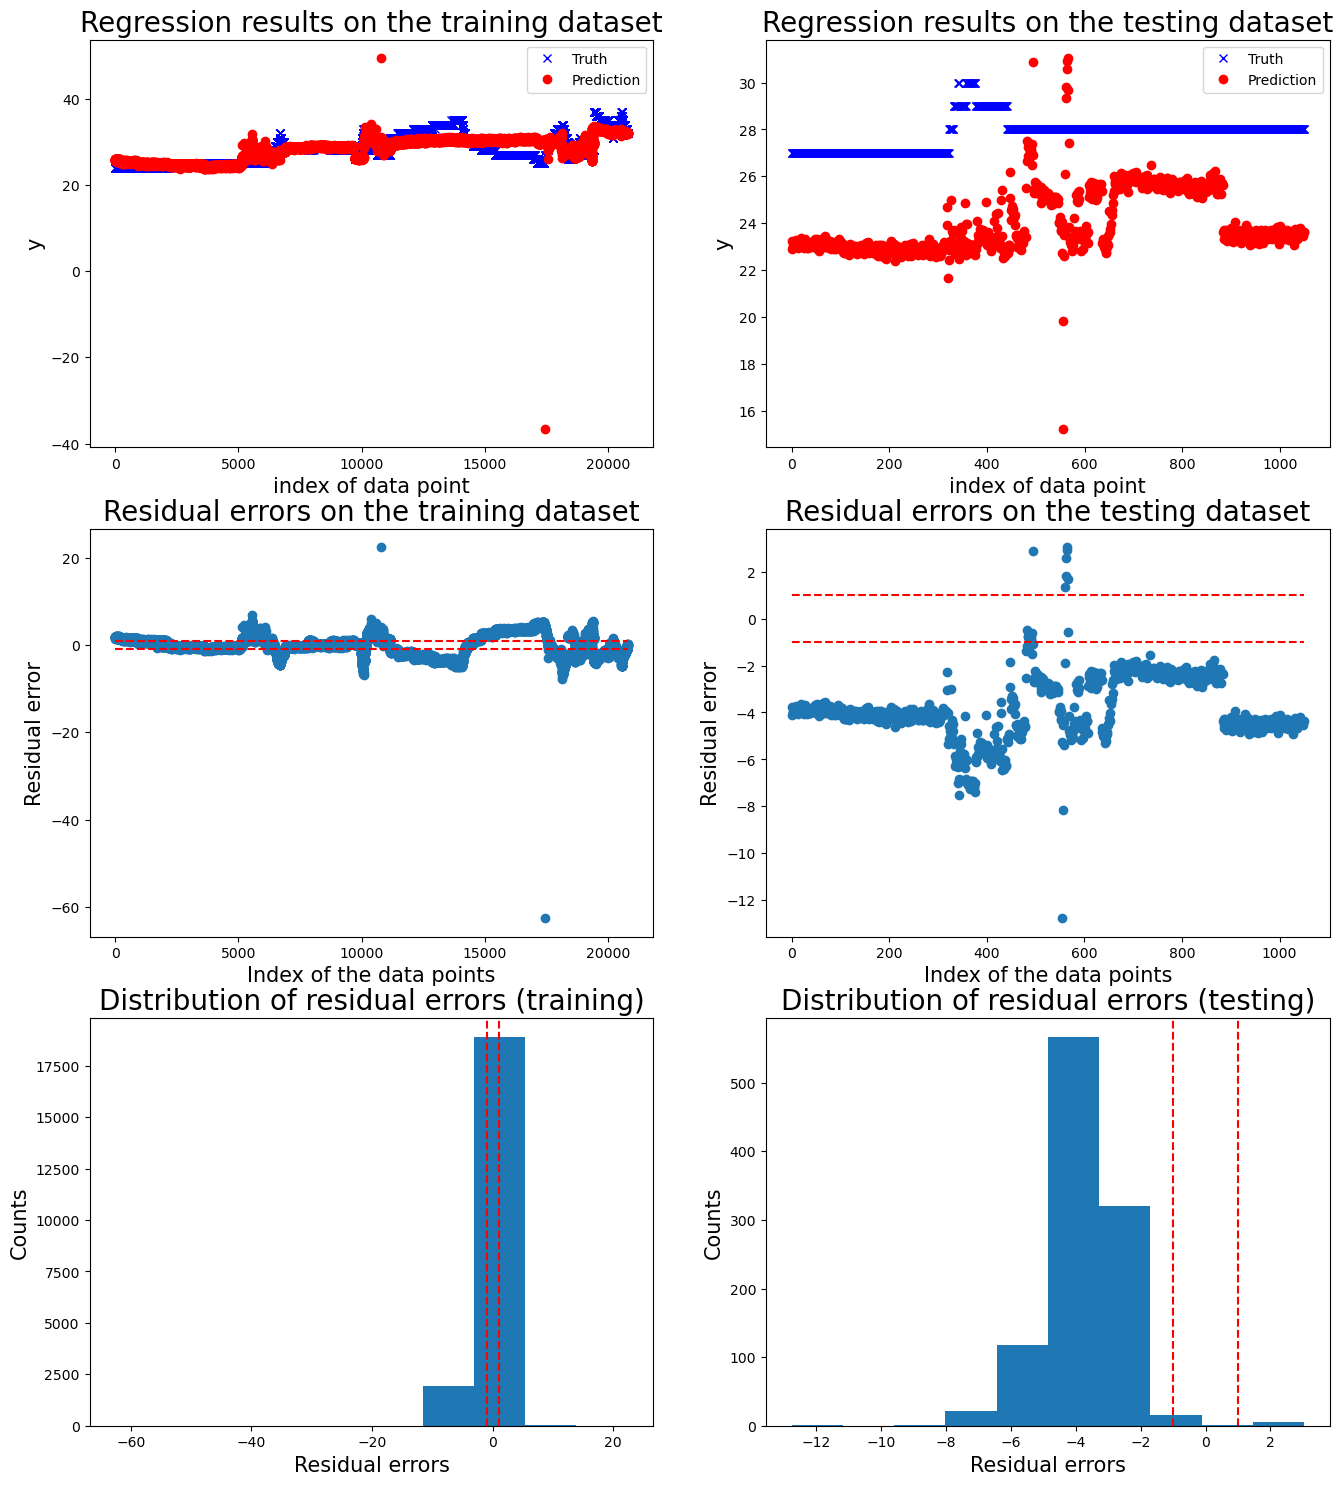

c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

training performance, max error is: 7.800681790432748
training performance, mean root square error is: 1.3750136887262514
training performance, residual error > 1: 26.904130352406213%

 New run:

testing performance, max error is: 25.19321907821046
testing performance, mean root square error is: 4.232480217719599
testing performance, residual error > 1: 63.643715341959336%


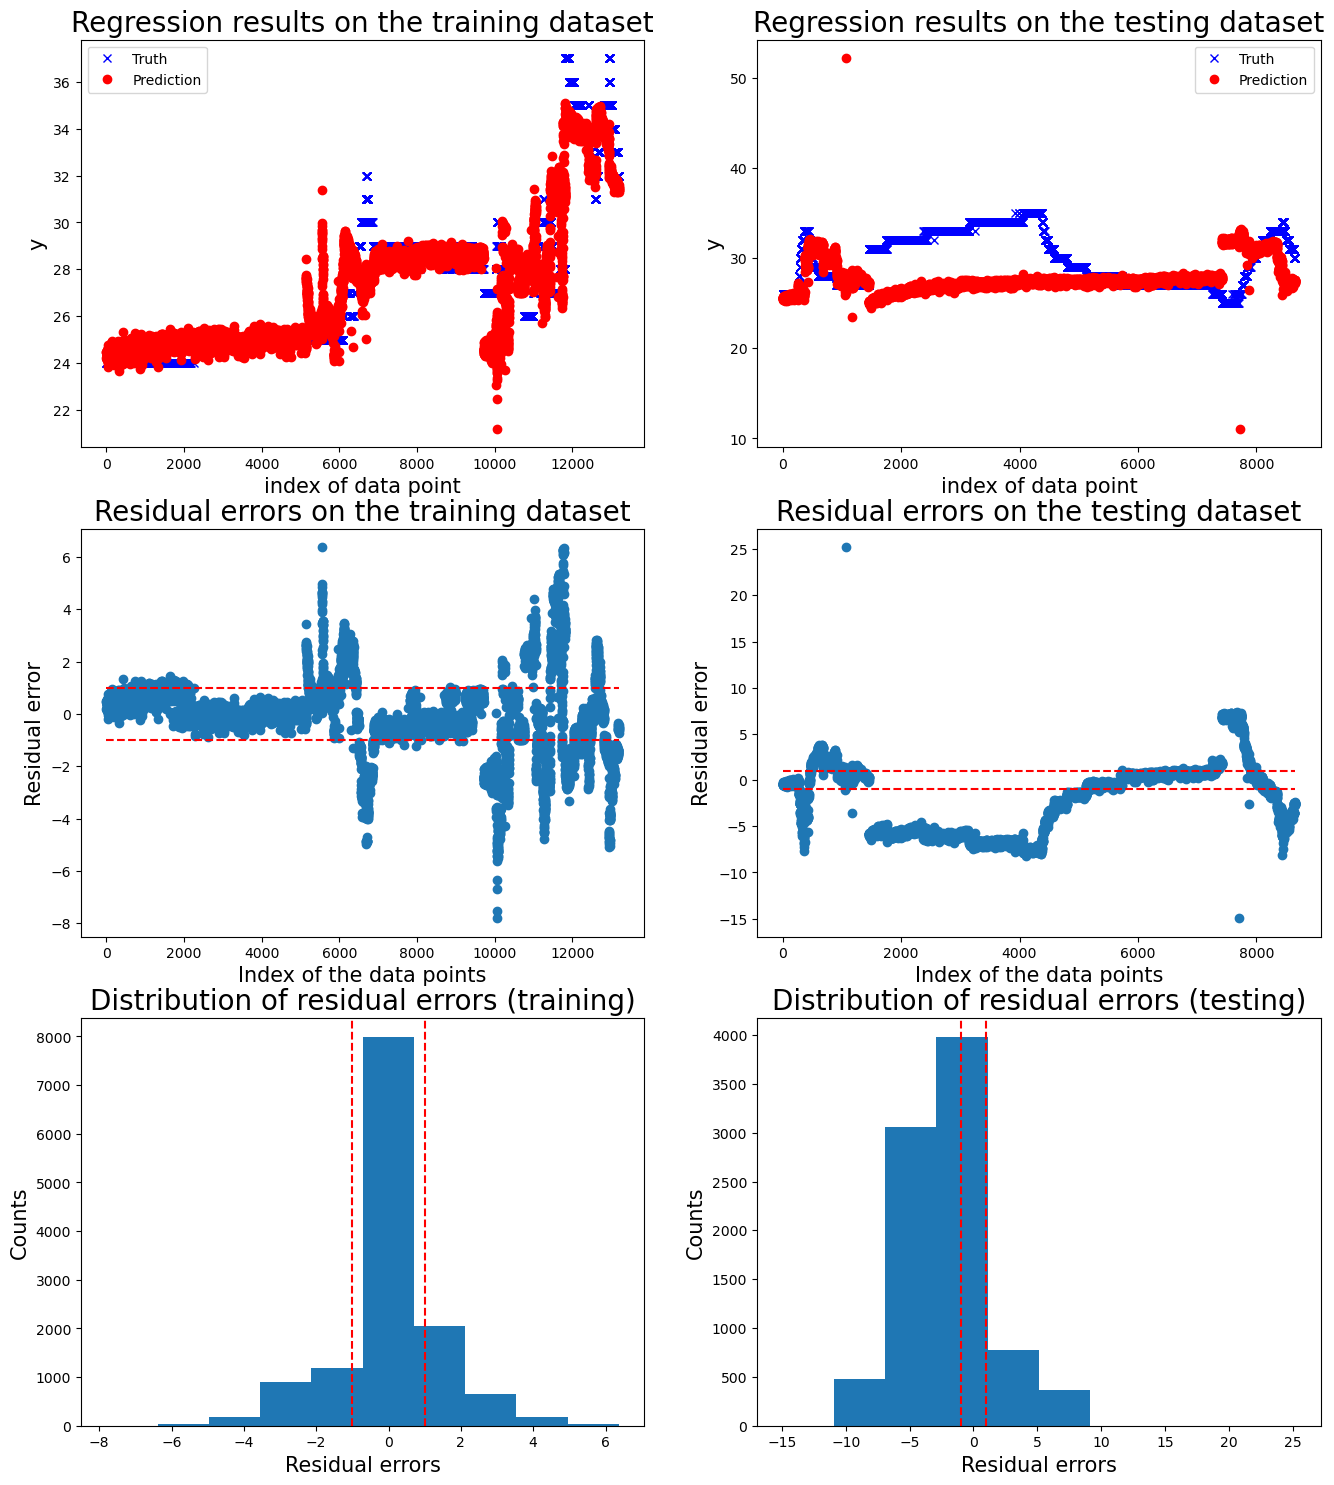

c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

training performance, max error is: 36.05371128887968
training performance, mean root square error is: 2.2229889997706955
training performance, residual error > 1: 58.098441423089675%

 New run:

testing performance, max error is: 6.871981881319279
testing performance, mean root square error is: 3.701899687558622
testing performance, residual error > 1: 75.60646900269542%


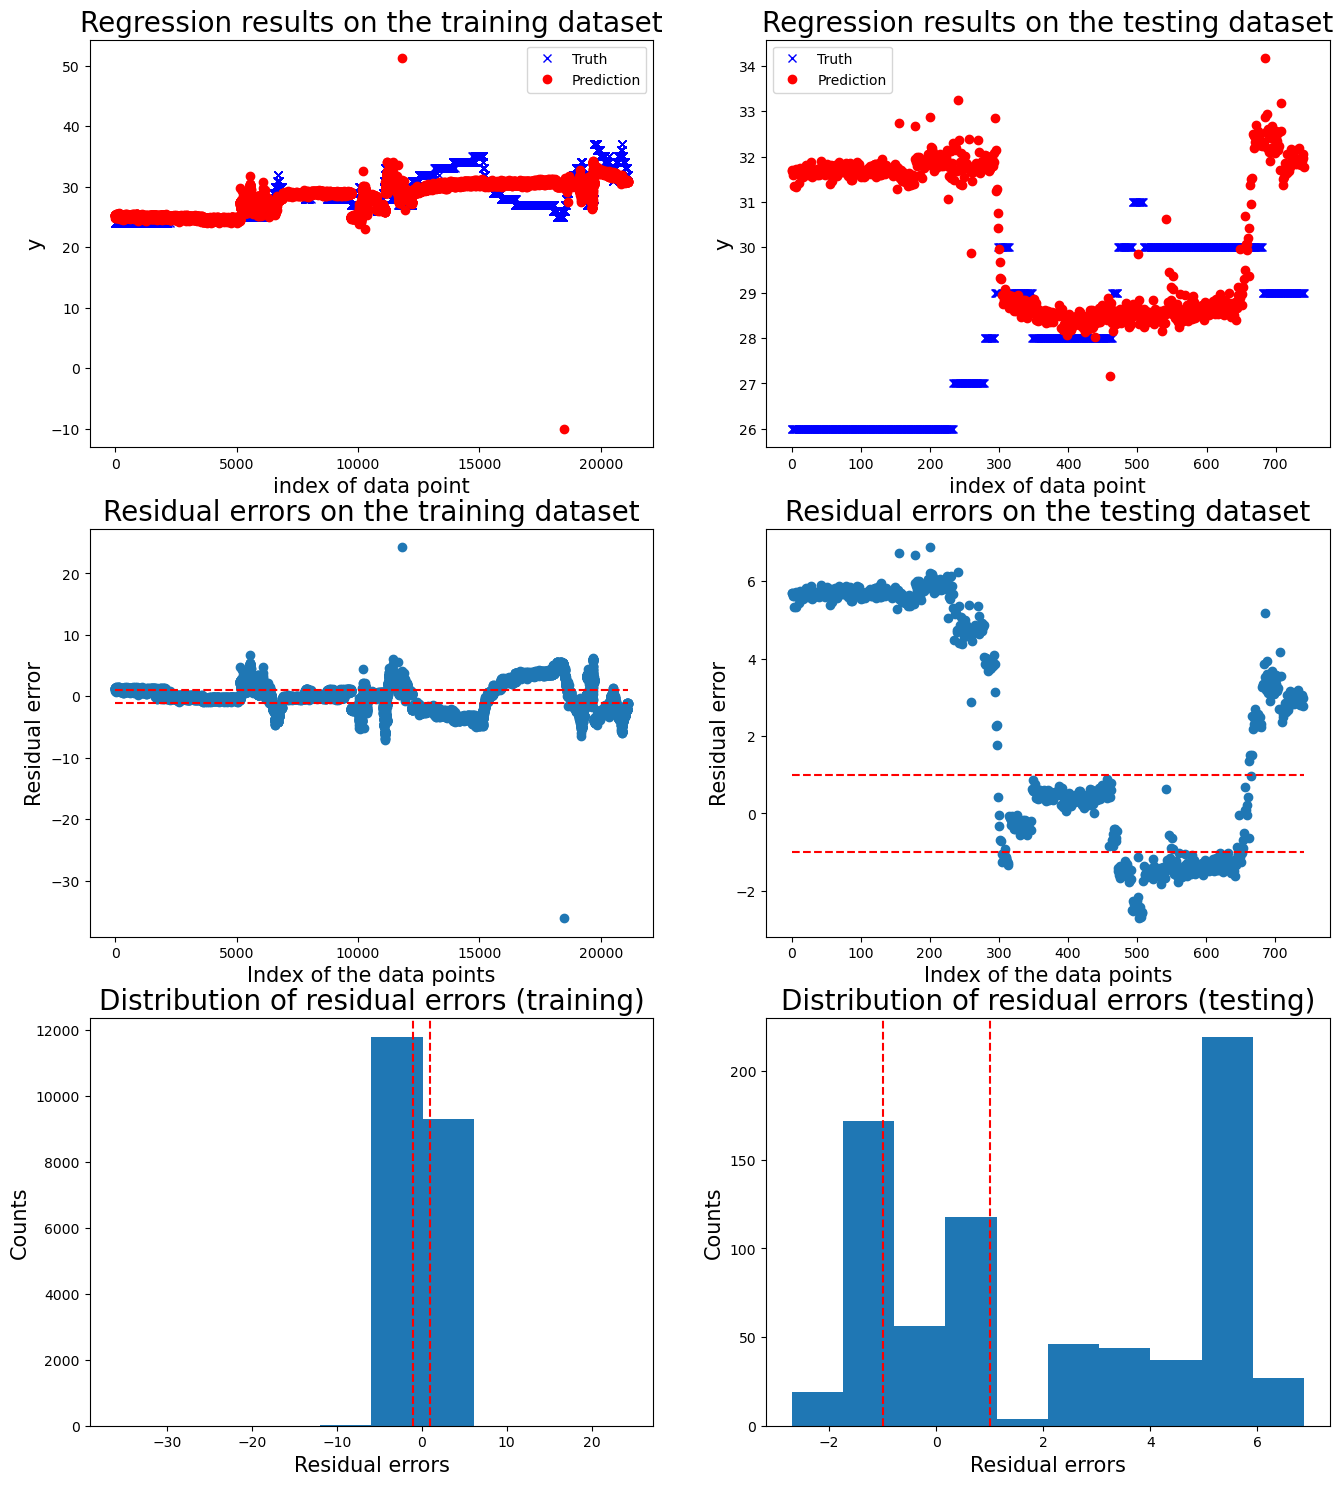

c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

training performance, max error is: 32.47586392637311
training performance, mean root square error is: 2.0517563375569248
training performance, residual error > 1: 56.09623015873015%

 New run:

testing performance, max error is: 10.66968289293964
testing performance, mean root square error is: 7.021779807471227
testing performance, residual error > 1: 87.40390301596689%


c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


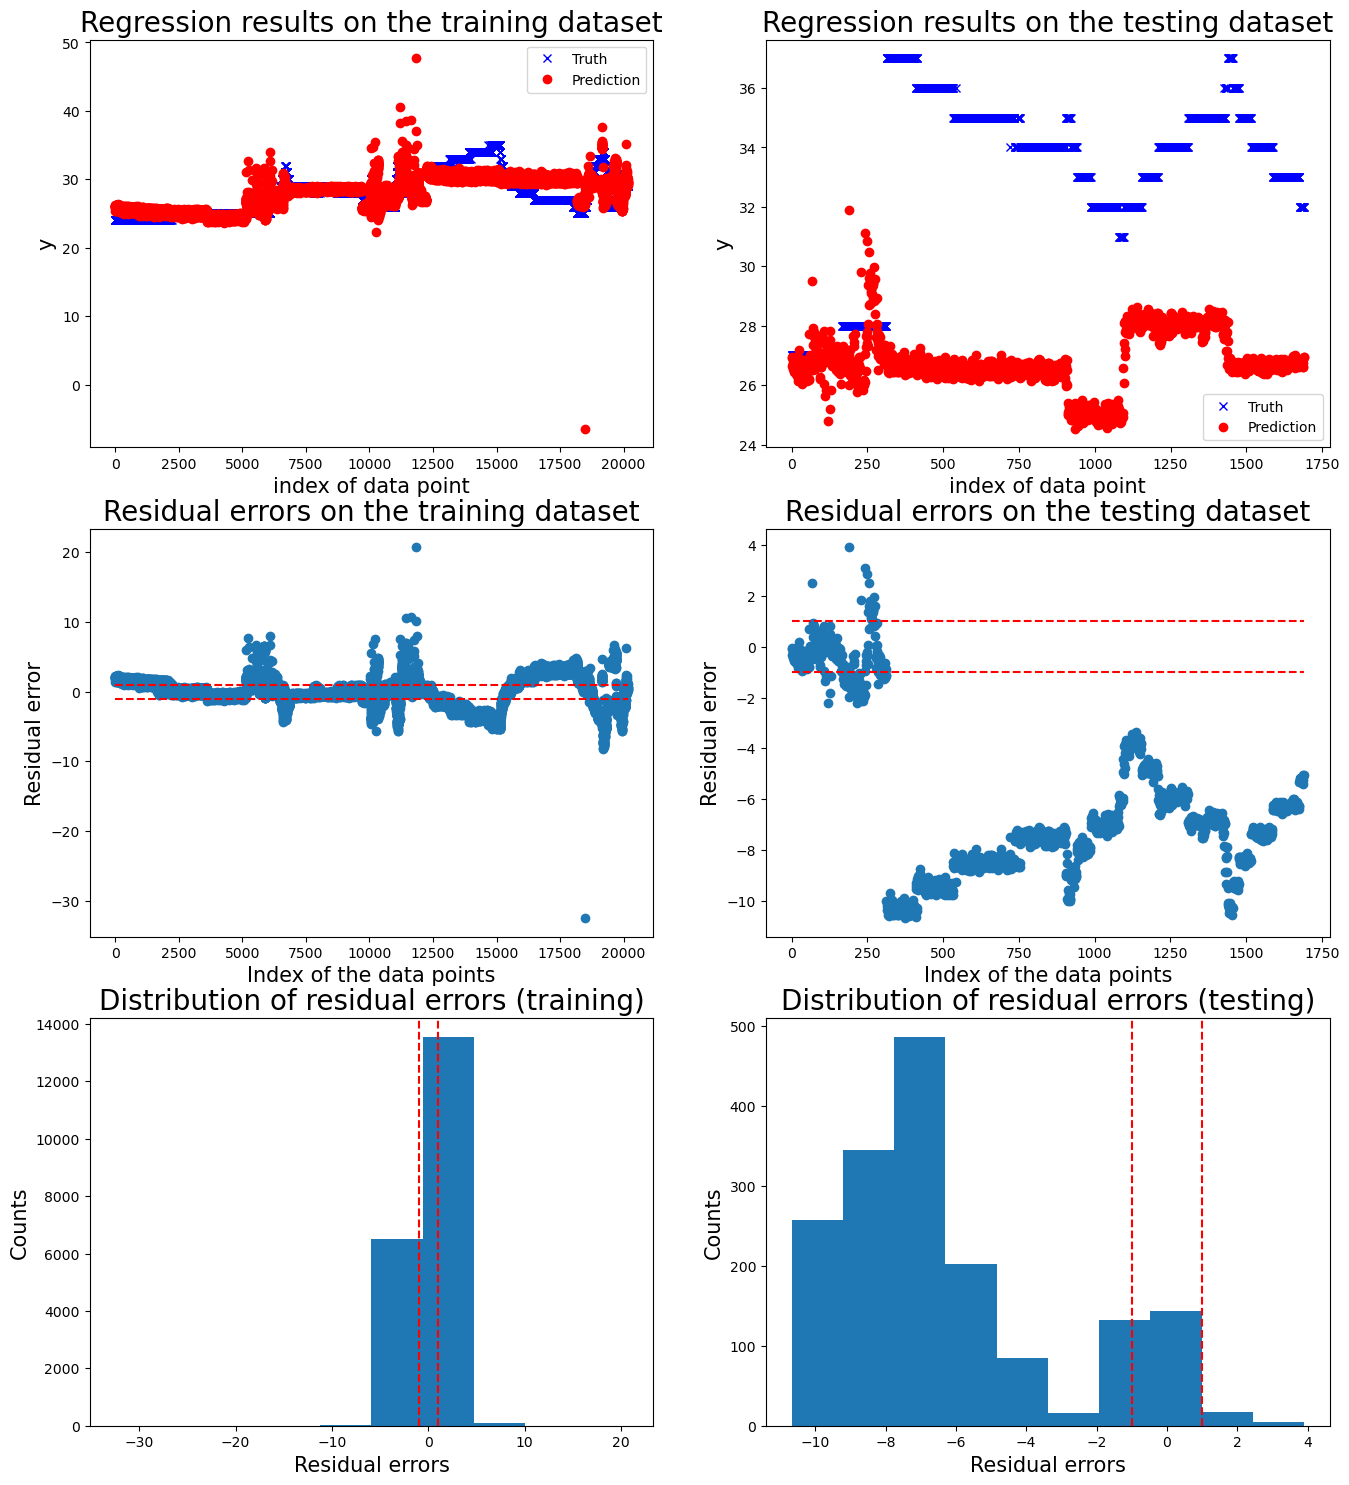

   Max error      RMSE  Exceed boundary rate
0  13.123969  4.521851              0.971376
1  12.759905  4.033491              0.990476
2  25.193219  4.232480              0.636437
3   6.871982  3.701900              0.756065
4  10.669683  7.021780              0.874039


Mean performance metric and standard error:
Max error: 13.7238 +- 6.8759
RMSE: 4.7023 +- 1.3305
Exceed boundary rate: 0.8457 +- 0.1495




In [21]:
# Model 1: all features
threshold = 1
df_all = run_cv_one_motor(motor_idx=6, df_data=df_data, mdl=mdl_linear_regreession, feature_list=features, n_fold=5, threshold=threshold, mdl_type='reg', single_run_result=False)

In [29]:
# Model 2: feature selection based on correlation matrix

X_data = pd.DataFrame(df_data, columns=features)
correlation_matrix = X_data.corr()
# plt.figure(figsize=(10, 10))  # Adjust width and height as needed
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
threshold = 0.25
selected_features_1 = correlation_matrix.columns[correlation_matrix.loc['data_motor_6_temperature'].abs() > threshold].tolist()

threshold = 1
df_sel_1 = run_cv_one_motor(motor_idx=6, df_data=df_data, mdl=mdl_linear_regreession, feature_list=selected_features_1, n_fold=5, threshold=threshold, mdl_type='reg', single_run_result=False)

Model for motor 6:


c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared

   Max error      RMSE  Exceed boundary rate
0   4.852029  2.130532              0.843801
1   8.790258  3.273211              0.997143
2  53.200395  3.754411              0.825208
3   6.705503  3.721872              0.832884
4   8.178076  4.778860              0.860438


Mean performance metric and standard error:
Max error: 16.3453 +- 20.6585
RMSE: 3.5318 +- 0.9580
Exceed boundary rate: 0.8719 +- 0.0713




c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Model for motor 6:


c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

training performance, max error is: 12.190540209956652
training performance, mean root square error is: 2.735487887904931
training performance, residual error > 1: 81.85188236263284%

 New run:

testing performance, max error is: 9.045765391687368
testing performance, mean root square error is: 4.386852544020841
testing performance, residual error > 1: 97.57001647446458%


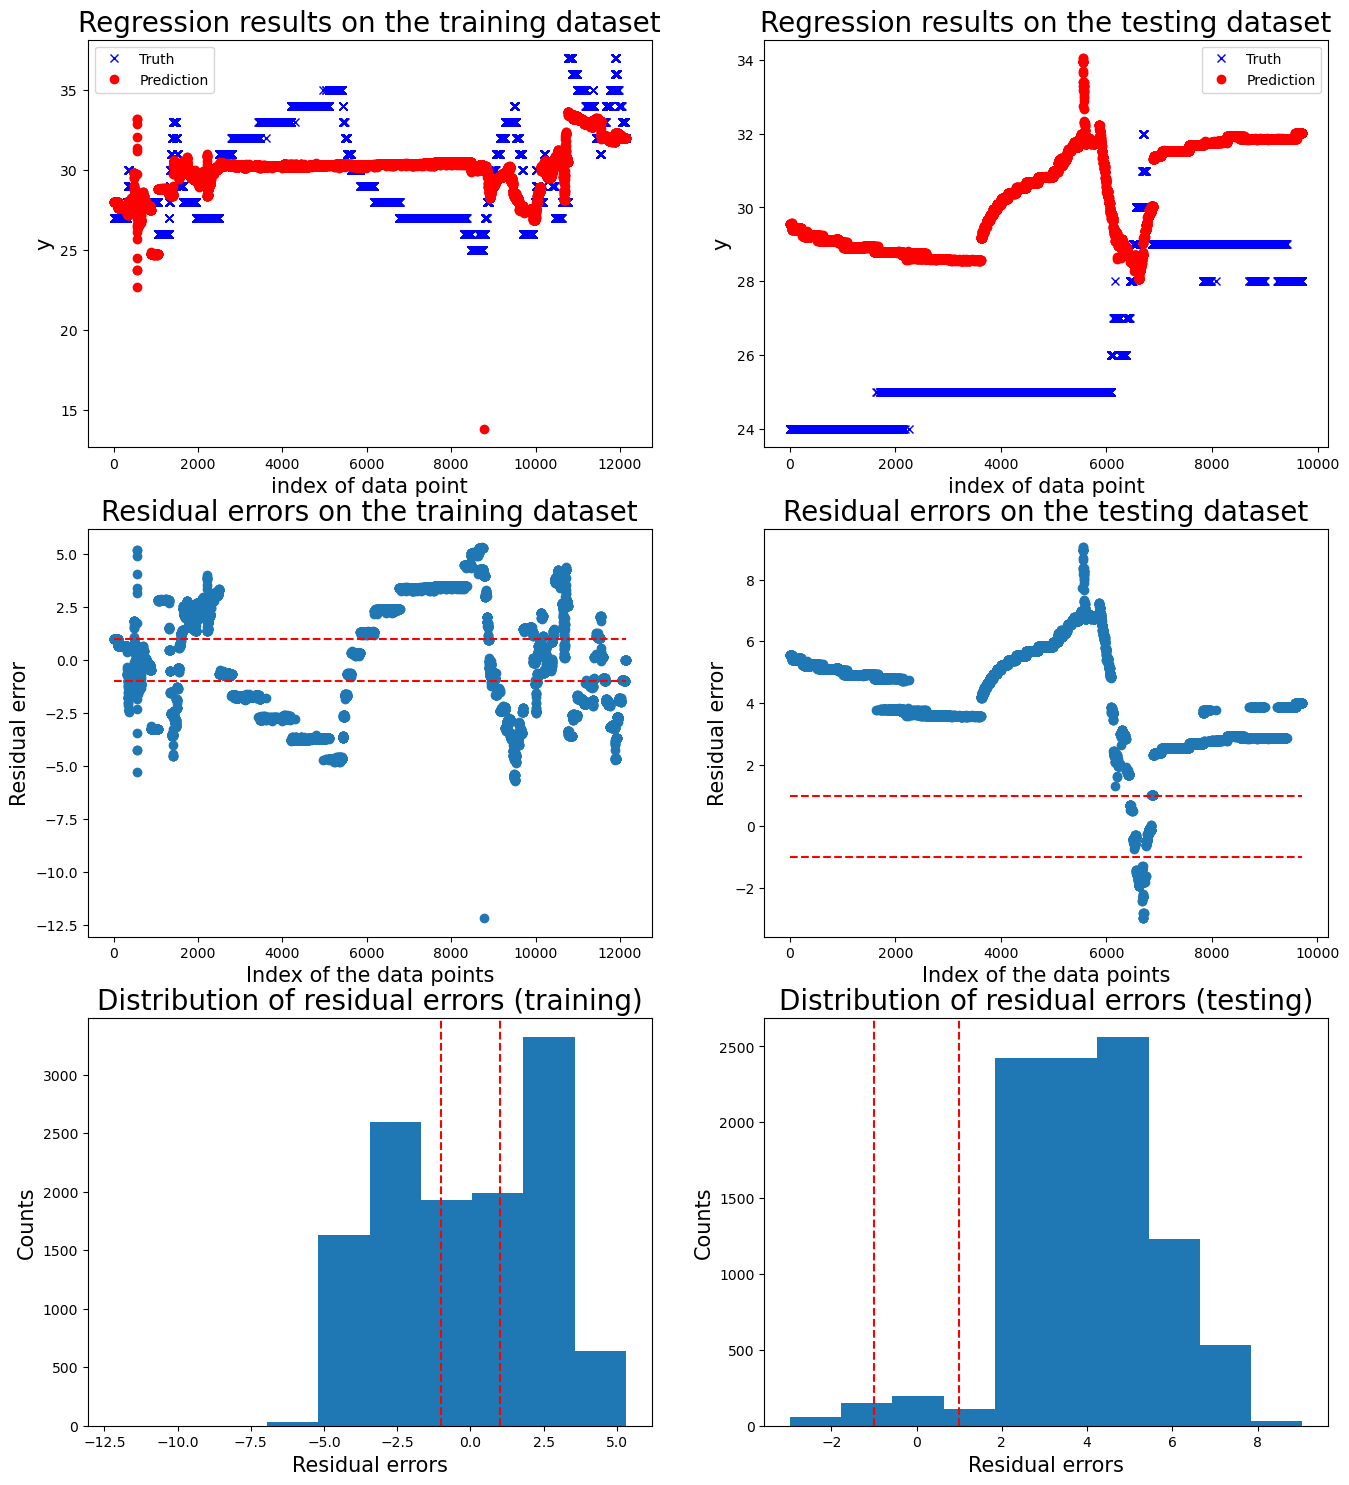

c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

training performance, max error is: 67.26985918432744
training performance, mean root square error is: 2.2427076764977936
training performance, residual error > 1: 62.222970049516846%

 New run:

testing performance, max error is: 14.139928145529826
testing performance, mean root square error is: 4.786638734822108
testing performance, residual error > 1: 99.90476190476191%


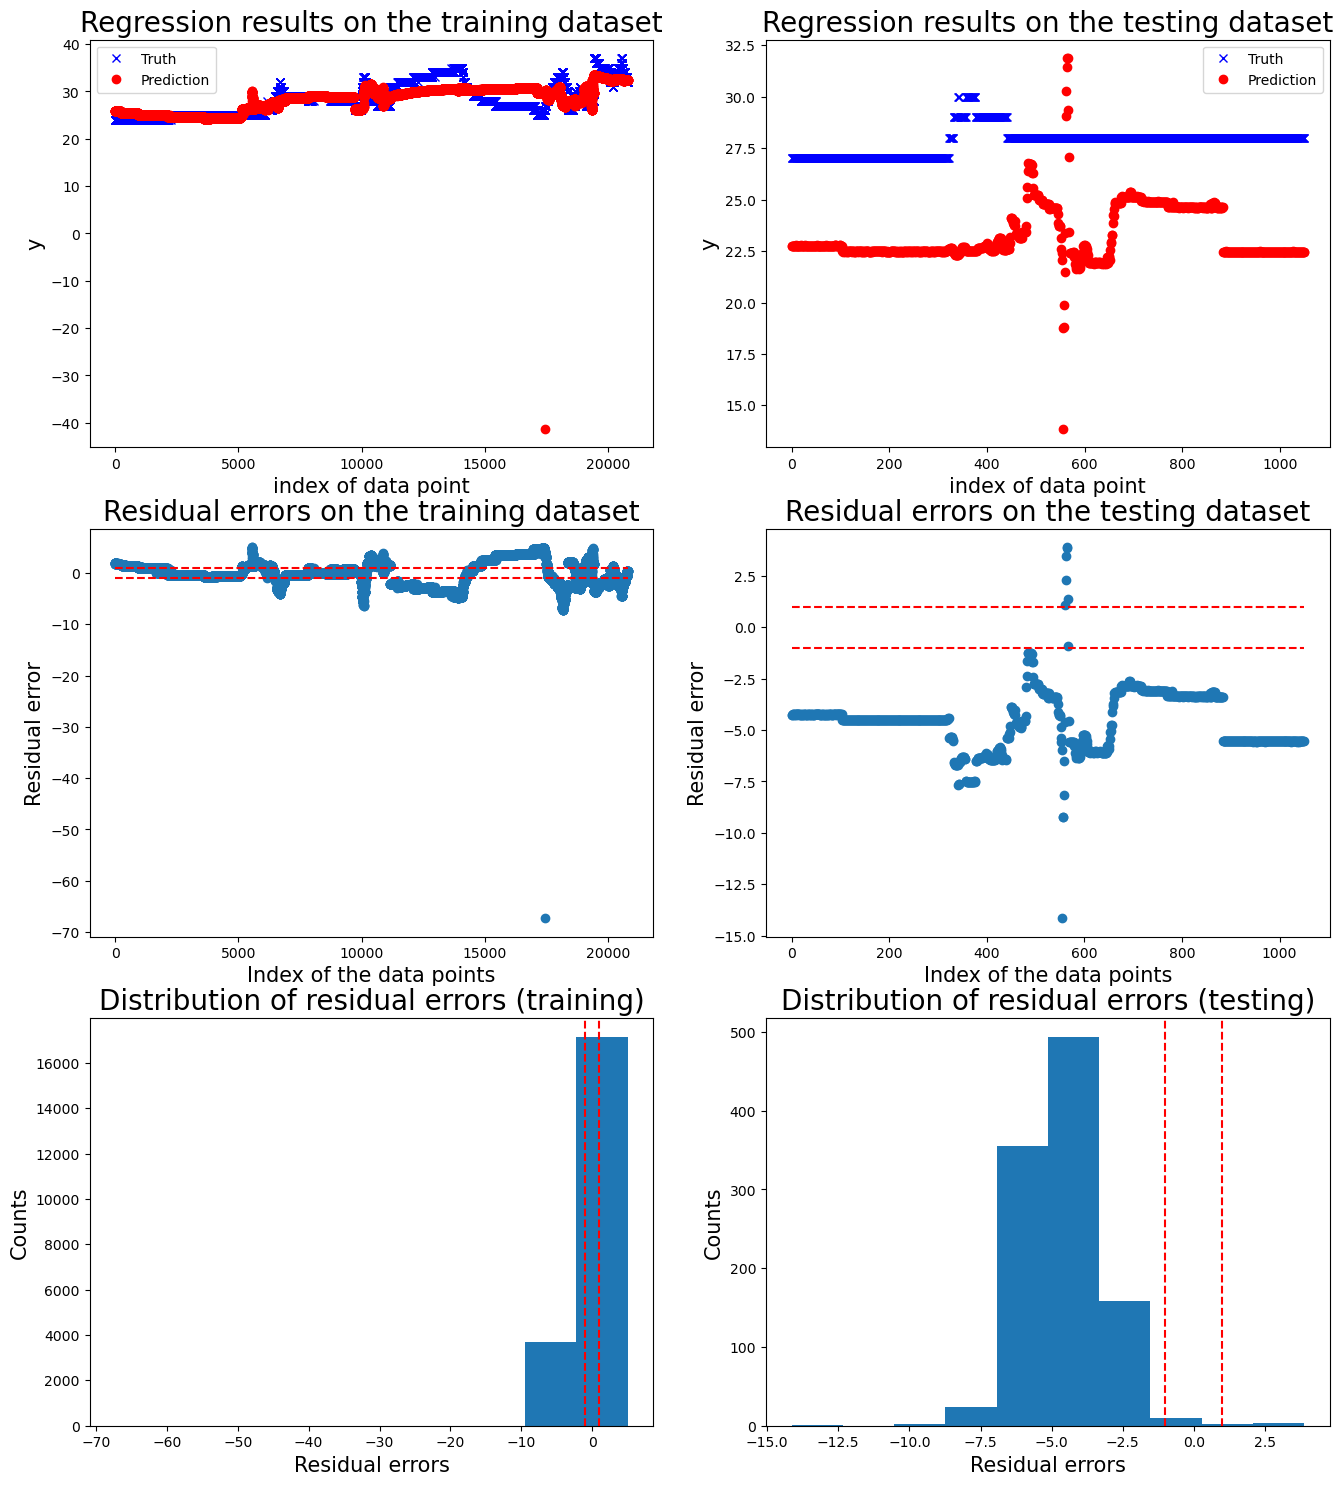

c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

training performance, max error is: 6.820956631379737
training performance, mean root square error is: 1.3953434422568018
training performance, residual error > 1: 25.40356195528609%

 New run:

testing performance, max error is: 18.81024768937995
testing performance, mean root square error is: 4.028403380380398
testing performance, residual error > 1: 75.06931608133087%


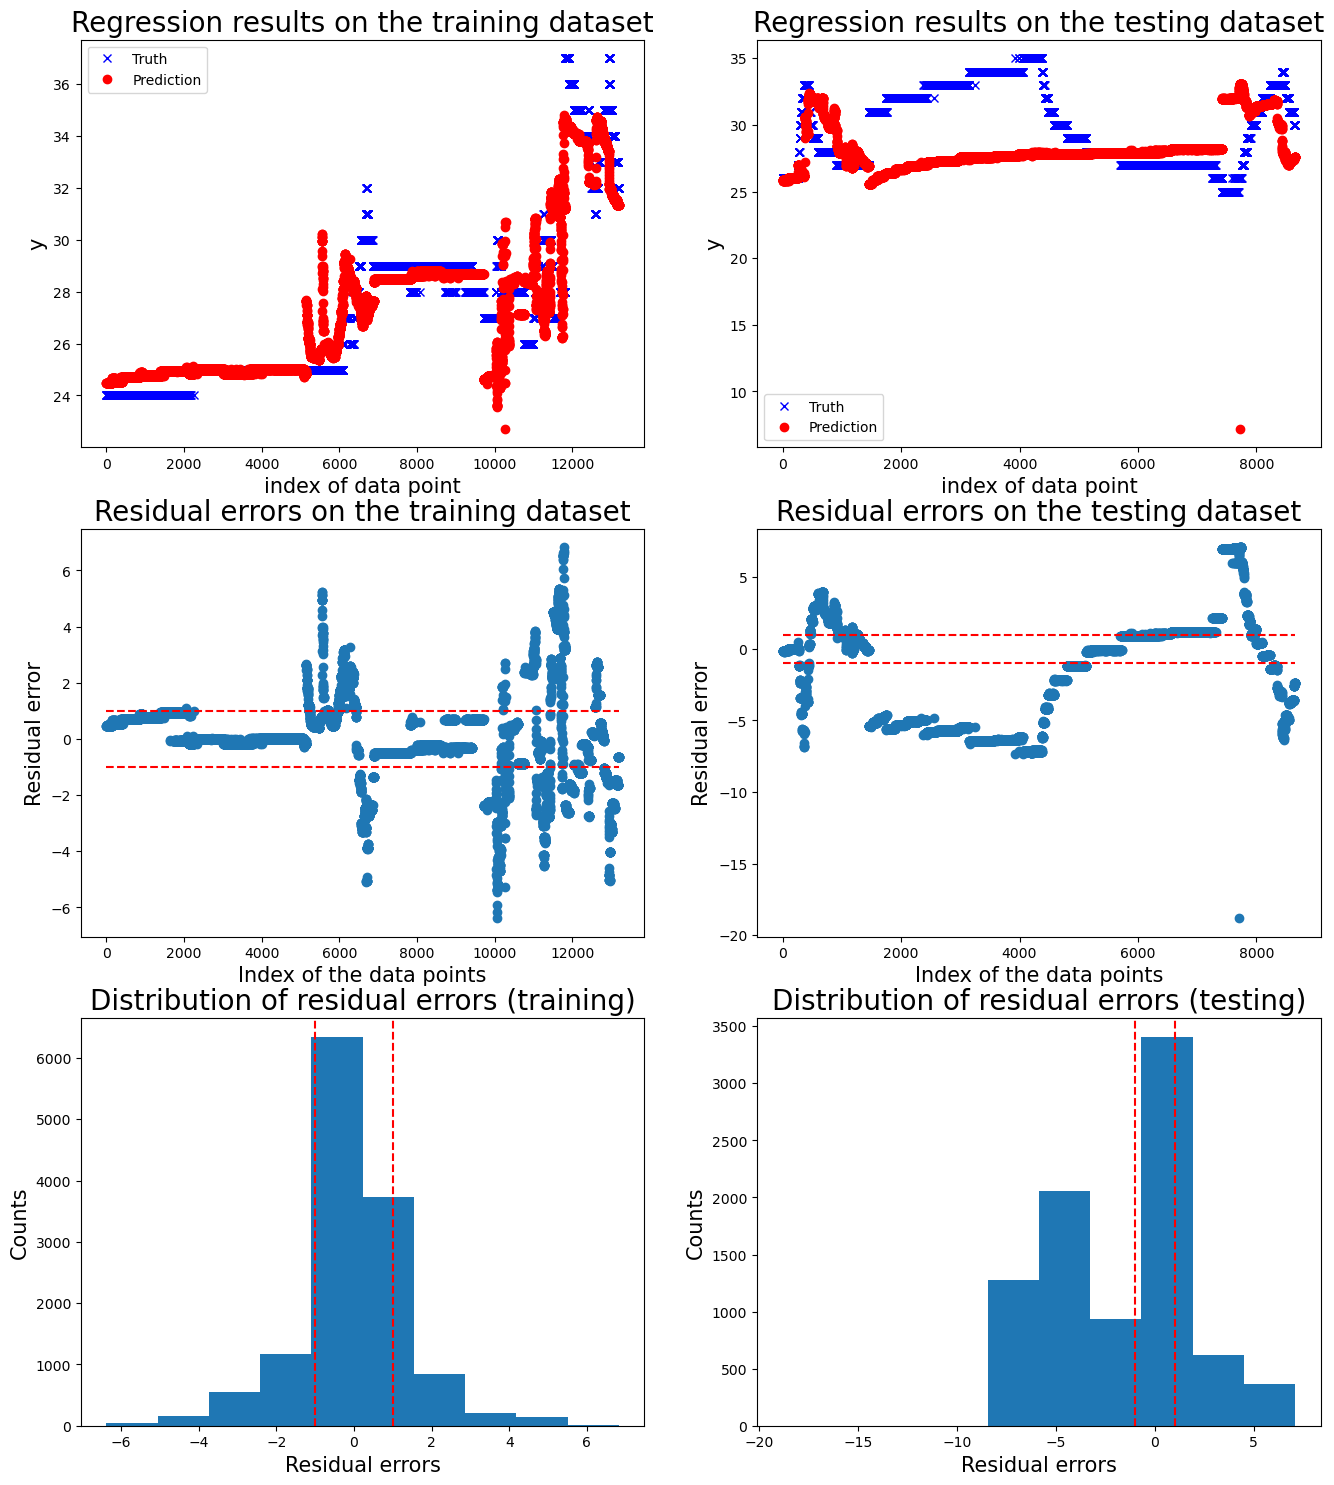

c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

training performance, max error is: 38.15831569964159
training performance, mean root square error is: 2.2611276077816256
training performance, residual error > 1: 59.96494386280733%

 New run:

testing performance, max error is: 6.994967300748428
testing performance, mean root square error is: 4.473018765236413
testing performance, residual error > 1: 75.47169811320755%


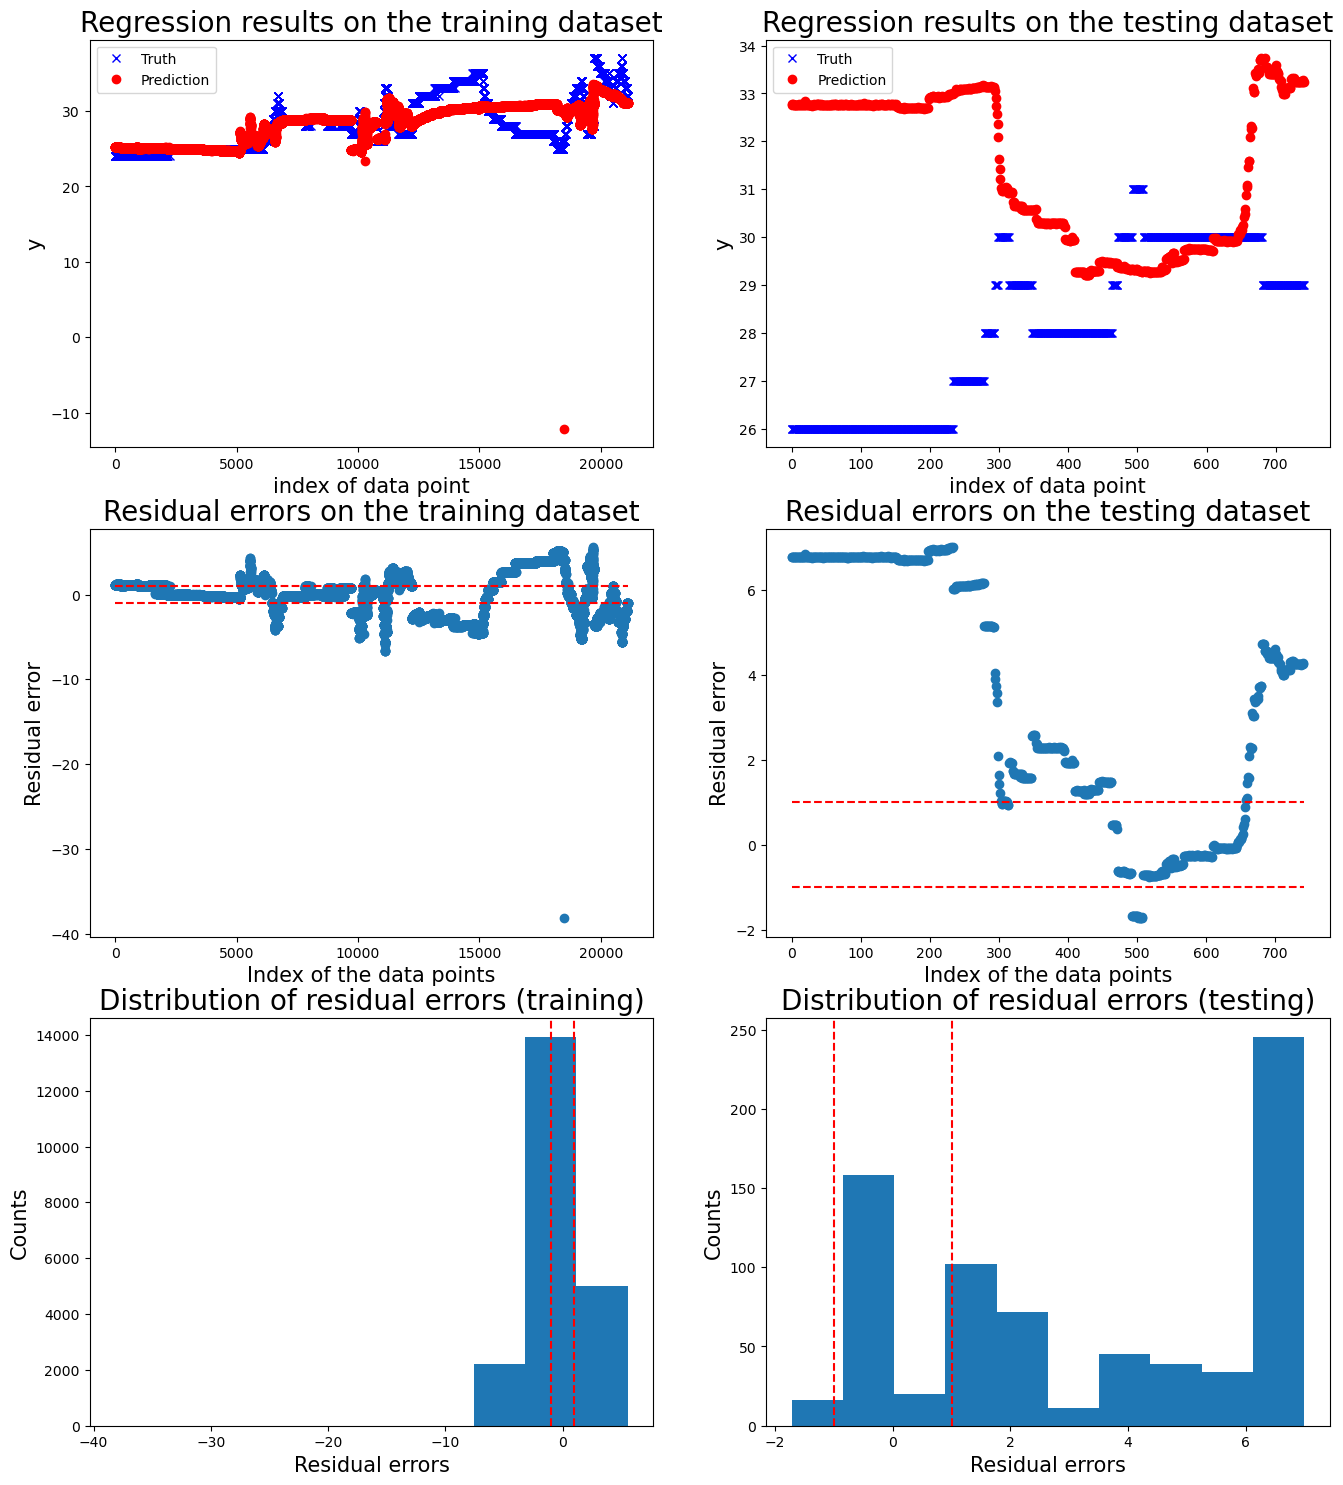

c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

training performance, max error is: 31.915326130691117
training performance, mean root square error is: 2.231346990333835
training performance, residual error > 1: 60.238095238095234%

 New run:

testing performance, max error is: 8.126197250646467
testing performance, mean root square error is: 4.7919078260867165
testing performance, residual error > 1: 85.74807806031933%


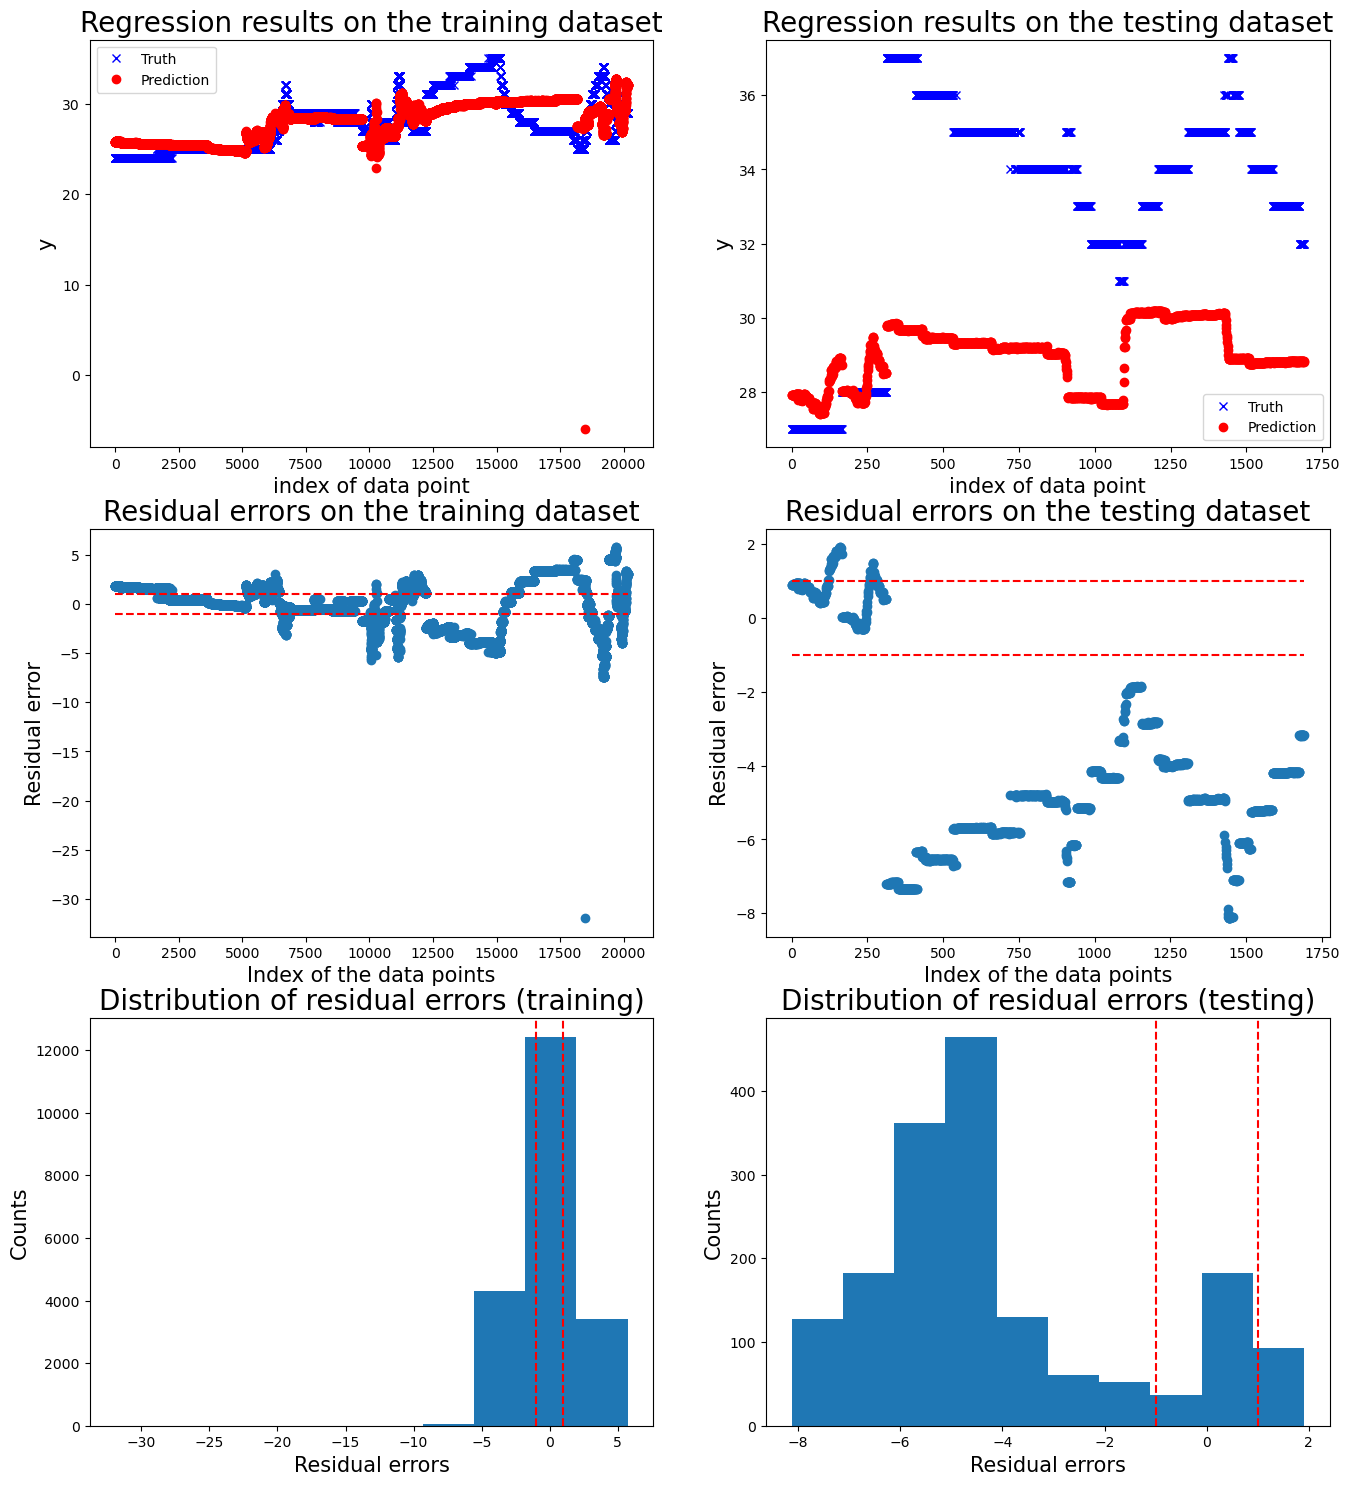

   Max error      RMSE  Exceed boundary rate
0   9.045765  4.386853              0.975700
1  14.139928  4.786639              0.999048
2  18.810248  4.028403              0.750693
3   6.994967  4.473019              0.754717
4   8.126197  4.791908              0.857481


Mean performance metric and standard error:
Max error: 11.4234 +- 4.9518
RMSE: 4.4934 +- 0.3174
Exceed boundary rate: 0.8675 +- 0.1178




In [27]:
# Model 3: voltage features excluded

features_no_voltage = ['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_2_position', 'data_motor_2_temperature',
                       'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_4_position', 'data_motor_4_temperature',
                       'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_6_position', 'data_motor_6_temperature']

threshold = 1
df_no_voltage = run_cv_one_motor(motor_idx=6, df_data=df_data, mdl=mdl_linear_regreession, feature_list=features_no_voltage, n_fold=5, threshold=threshold, mdl_type='reg', single_run_result=False)

In [35]:
# Model 4: all features, data smoothing

df_smoothing = df_data.copy()

def smoothing(data, experiment, feature, dim):

    ds = data.loc[data['test_condition'] == experiment]
    ds = pd.DataFrame(ds, columns=['time', 'indice', feature])

    ds['aver'] = ds[feature].rolling(dim).mean()

    dict = ds.set_index('indice')['aver'].to_dict()
    for idx, row in data.iterrows():
     if row['indice'] in dict:
        data.at[idx, feature] = dict[row['indice']]

    return data

for i in range(len(normal_test_id)):
   for j in range(len(features)):
     df_smoothing = smoothing(df_smoothing, normal_test_id[i], features[j], 25)

df_smoothing = df_smoothing.dropna()

threshold = 1
df_all = run_cv_one_motor(motor_idx=6, df_data=df_smoothing, mdl=mdl_linear_regreession, feature_list=features, n_fold=5, threshold=threshold, mdl_type='reg', single_run_result=False)

Model for motor 6:


c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared

   Max error      RMSE  Exceed boundary rate
0  11.234058  4.052878              0.932780
1   7.431778  4.517819              0.997955
2  22.769134  3.197044              0.824674
3   5.396482  2.830593              0.832836
4  11.373792  7.575421              0.914762


Mean performance metric and standard error:
Max error: 11.6410 +- 6.7228
RMSE: 4.4348 +- 1.8789
Exceed boundary rate: 0.9006 +- 0.0726




c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [36]:
# Model 5: feature selection based on correlation matrix, data smoothing

X_data = pd.DataFrame(df_smoothing, columns=features)
correlation_matrix = X_data.corr()
# plt.figure(figsize=(10, 10))  # Adjust width and height as needed
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
threshold = 0.25
selected_features_2 = correlation_matrix.columns[correlation_matrix.loc['data_motor_6_temperature'].abs() > threshold].tolist()

threshold = 1
df_sel_2 = run_cv_one_motor(motor_idx=6, df_data=df_smoothing, mdl=mdl_linear_regreession, feature_list=selected_features_1, n_fold=5, threshold=threshold, mdl_type='reg', single_run_result=False)

Model for motor 6:


c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared

   Max error      RMSE  Exceed boundary rate
0   5.661358  1.817617              0.676141
1   7.500289  4.361183              1.000000
2  15.690769  8.362239              0.907153
3   8.592429  5.207307              1.000000
4   9.873369  6.085346              0.860408


Mean performance metric and standard error:
Max error: 9.4636 +- 3.8084
RMSE: 5.1667 +- 2.3939
Exceed boundary rate: 0.8887 +- 0.1333




c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [37]:
# Model 6: voltage features excluded, data smoothing

features_no_voltage = ['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_2_position', 'data_motor_2_temperature',
                       'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_4_position', 'data_motor_4_temperature',
                       'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_6_position', 'data_motor_6_temperature']

threshold = 1
df_no_voltage_2 = run_cv_one_motor(motor_idx=6, df_data=df_smoothing, mdl=mdl_linear_regreession, feature_list=features_no_voltage, n_fold=5, threshold=threshold, mdl_type='reg', single_run_result=False)

Model for motor 6:


c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared

   Max error      RMSE  Exceed boundary rate
0   8.550900  4.464727              0.974274
1   8.910532  6.313933              1.000000
2   7.194869  4.036268              0.760834
3   7.248788  4.774894              0.759701
4   7.715723  4.771697              0.854231


Mean performance metric and standard error:
Max error: 7.9242 +- 0.7741
RMSE: 4.8723 +- 0.8607
Exceed boundary rate: 0.8698 +- 0.1141




c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**Summary of the results - Only using features from the current moment**

Please add a table in the end, summarying the results from all the models. Please write a few texts to explain what is the best model you got (including the features and preprocessing you did), its performance, and how could you further improve it.

| Model   | Max error | MRSE | Exceed boundary rate |
|---------|----------|-----------|--------|
| Model 1 |   XX.X%  |   XX.X%   |  XX.X% | 
| Model 2 |   XX.X%  |   XX.X%   |  XX.X% | 
| Model 3 |   XX.X%  |   XX.X%   |  XX.X% | 

## Sub-task 2: Include the features in the past

Now, let's consider using the sliding window approach to include the past in the regression model as well. Please have a look at the demo notebook, run your experiment, and report the best models you could have if you apply the sliding window approach.

**Summary of the results - Sliding window**

Please add a table in the end, summarying the results from all the models. Please write a few texts to explain what is the best model you got (including the features and preprocessing you did), its performance, and how could you further improve it.

| Model   (also report parameters like window_size, sample_step, prediction_lead_time, etc.) | Max error | MRSE | Exceed boundary rate |
|---------|----------|-----------|--------|
| Model 1 |   XX.X%  |   XX.X%   |  XX.X% | 
| Model 2 |   XX.X%  |   XX.X%   |  XX.X% | 
| Model 3 |   XX.X%  |   XX.X%   |  XX.X% | 

# Task 2 Fault detection based on regression model

In this exercise, we use the dataset that contains the failure of motor 6 to test the fault detection model based on the regression model trained before. 

[This notebook](demo_FaultDetectReg.ipynb) presents a demonstration of how to use the provided supporting function to develop fault detection model based on the regression model. Please have a look at this notebook, and try to improve the performance of the baseline model.

In [ ]:
# Your code here:

## Summary of the results

Please add a table in the end, summarying the results from all the models (including the unsupervised learning models). Please write a few texts to explain what is the best model you got (including key parameters like threshold, window_size, sample_step, prediction_lead_time, etc), its performance, and how could you further improve it.

| Model   | Accuracy | Precision | Recall | F1   |
|---------|----------|-----------|--------|------|
| Model 1 |   XX.X%  |   XX.X%   |  XX.X% | XX.X%|
| Model 2 |   XX.X%  |   XX.X%   |  XX.X% | XX.X%|
| Model 3 |   XX.X%  |   XX.X%   |  XX.X% | XX.X%|
